In [1]:
import os
import sys
sys.path.insert(0, os.path.join('..'))

import numpy as np
import matplotlib.pyplot as plt
import radial as rd
from radial.dataset import Batch, Dataset, FilesIndex, Pipeline, R, B, V, action, inbatch_parallel
from radial.dataset.models.tf import ResNet18
from radial.core import RadialBatch
plt.style.use('ggplot')
%matplotlib inline

In [2]:
ix = FilesIndex(path='./data/*')
dataset = Dataset(ix, RadialBatch)

In [3]:
rad_ppl = (Pipeline()
       .load(fmt='npz')
       .delete_outliers()
       .get_samples(100, sampler=np.random.random)
) << dataset

In [4]:
batch = rad_ppl.next_batch(2, shuffle=True)

In [5]:
model_config = {
    'inputs': dict(points=dict(shape=(2, 100)),
                   targets=dict(name='target', shape=1)),
    'initial_block/inputs': 'points',
    'head/num_classes': 1,
    'loss': 'mse',
    'optimizer': 'Adam'
}

In [6]:
def concatenate_points(batch, model, return_targets=True):
    _ = model
    zip_data = zip(batch.time, batch.derivative)
    points = np.array(list(map(lambda d: np.array([d[0],d[1]]).reshape(-1, batch.derivative[0].shape[1]), zip_data)))
    res_dict = {'feed_dict': {'points': points}}
    if return_targets:
        y = batch.target.reshape(-1, 1)
        res_dict['feed_dict']['targets'] = y
    return res_dict

In [7]:
train_pipeline = (Pipeline()
                  .init_variable('loss', init_on_each_run=list)
                  .init_variable('pred', init_on_each_run=list)
                  .init_variable('true_val', init_on_each_run=list)
                  .init_model('dynamic', ResNet18, 'point', config=model_config)
                  .train_model('point', fetches=['loss', 'predictions', 'targets'], make_data=concatenate_points,
                               save_to=[V('loss'), V('pred'), V('true_val')], mode='a')
)

In [8]:
train_pipeline = (rad_ppl + train_pipeline)

In [ ]:
train_pipeline.next_batch(50, shuffle=True)

In [33]:
train_pipeline.run(50, shuffle=True, n_epochs=5, drop_last=True, bar=True)

100%|██████████| 55/55 [01:39<00:00,  1.84s/it]


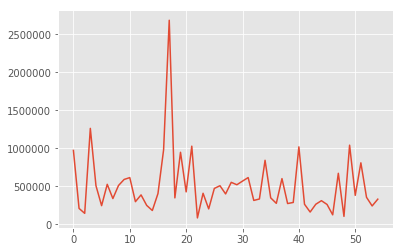

In [34]:
plt.plot(train_pipeline.get_variable('loss'))

In [42]:
pred_pipeline = (Pipeline()
                .init_variable('predictions', init_on_each_run=list)
                .init_variable('targets', init_on_each_run=list) 
                .init_variable('points', init_on_each_run=list) 
                .import_model('point', train_pipeline)
                .update_variable("targets", B('target'), mode='e')
                .predict_model('point', fetches=['predictions','points'], 
                                make_data=concatenate_points,
                                save_to=[V('predictions'), V('points')], mode='a')
)         
pred_pipeline = (rad_ppl + pred_pipeline).run(50, shuffle=True, n_epochs=1, drop_last=True, bar=True)



  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  3.76it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.13it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.67it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.44it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.07it/s]

 64%|██████▎   | 7/11 [00:03<00:02,  1.91it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  1.96it/s]

 82%|████████▏ | 9/11 [00:04<00:01,  1.94it/s]

 91%|█████████ | 10/11 [00:04<00:00,  1.97it/s]

100%|██████████| 11/11 [00:05<00:00,  1.99it/s]



In [77]:
point = np.array(pred_pipeline.get_variable('points')).reshape(-1, 2, 100)
target = np.array(pred_pipeline.get_variable('targets'))
predictions = np.array(pred_pipeline.get_variable('predictions')).reshape(-1)

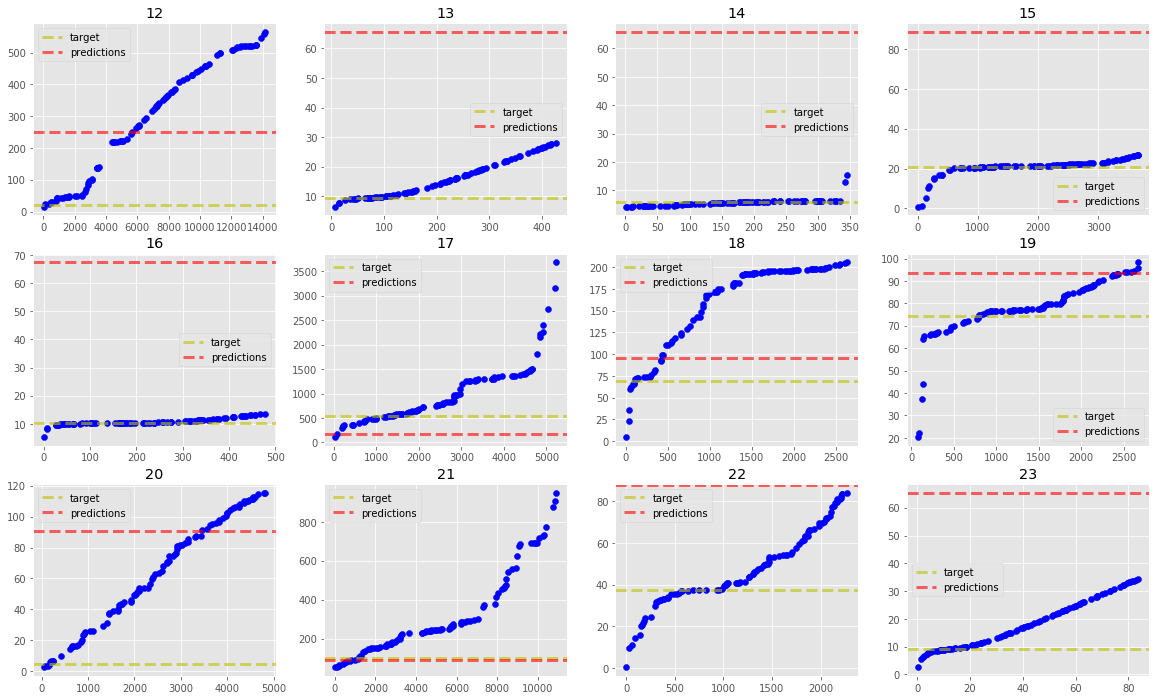

In [80]:
_, ax = plt.subplots(3, 4, figsize=(20, 12))
ax = ax.reshape(-1)
s = 12
for i in range(s, s+12):
    x = np.array(sorted(point[i].T[:,0]))
    y = np.array(sorted(point[i].T[:,1]))
    ax[i-s].scatter(x, y, c='b')
    ax[i-s].axhline(target[i], ls='--', c='y', lw=3, alpha=0.6, label='target')
    ax[i-s].axhline(predictions[i], ls='--', c='r', lw=3, alpha=0.6, label='predictions')
    ax[i-s].set_title('{}'.format(i))
    ax[i-s].legend()